In [1]:
import numpy as np
import matplotlib.pyplot as plt
from halotools.sim_manager import CachedHaloCatalog, TabularAsciiReader

%matplotlib inline

In [2]:
halocat = CachedHaloCatalog(simname='bolplanck')
#Vbox_source = np.prod(halocat.Lbox)

source_fname = "/Users/hsa23/Desktop/workshops/lsst/Millenium/z0_xyz_0_100_sm_1e9_guo.txt"
columns = {'halo_id':(0,'i8'),'halo_hostid':(6,'i8'),'x':(17,'f4'),'y':(18,'f4'),'z':(19,'f4'),
           'sm':(40,'f4'),'bhmass':(44,'f4'),'sfr':(52,'f4'),'u_mag':(61,'f4'),
           'vmax':(27,'f4'),'mvir':(24,'f4')}
reader = TabularAsciiReader(source_fname, columns) 

from astropy.table import Table 
source_gals = Table(reader.read_ascii())
source_gals['mvir'] *= 1e10
source_gals['sm'] *= 1e10


...Processing ASCII data of file: 
/Users/hsa23/Desktop/workshops/lsst/Millenium/z0_xyz_0_100_sm_1e9_guo.txt
 
Total number of rows in detected data = 10154
Number of rows in detected header = 96 

... working on chunk 0 of 1
Total runtime to read in ASCII = 0.19 seconds




In [3]:
source_fname = "/Users/hsa23/Desktop/workshops/lsst/Millenium/z0_xyz_0_100_halo.txt"
columns = {'x':(0,'f4'),'y':(1,'f4'),'z':(2,'f4'),'halo_mvir':(3,'f4'),'halo_id':(4,'i8'),'tree_id':(5,'i8')}
reader = TabularAsciiReader(source_fname, columns) 

from astropy.table import Table
source_halos = reader.read_ascii()
source_halos['halo_mvir'] *= -1e10

source_halos = Table(np.sort(source_halos,order=['tree_id','halo_mvir']))
source_halos['halo_mvir'] *= -1

u, indices = np.unique(source_halos['tree_id'],return_index=True)
source_halos = source_halos[indices]
source_halos=source_halos[source_halos['halo_mvir']>0]


...Processing ASCII data of file: 
/Users/hsa23/Desktop/workshops/lsst/Millenium/z0_xyz_0_100_halo.txt
 
Total number of rows in detected data = 37028
Number of rows in detected header = 19 

... working on chunk 0 of 1
Total runtime to read in ASCII = 0.23 seconds




In [4]:
from halotools.utils import crossmatch
idx_subs, idx_hosts = crossmatch(source_gals['halo_hostid'], source_halos['tree_id'])
source_gals['halo_x'] = np.zeros(len(source_gals), dtype = source_halos['x'].dtype)
source_gals['halo_x'][idx_subs] = source_halos['x'][idx_hosts]
source_gals['halo_y'] = np.zeros(len(source_gals), dtype = source_halos['y'].dtype)
source_gals['halo_y'][idx_subs] = source_halos['y'][idx_hosts]
source_gals['halo_z'] = np.zeros(len(source_gals), dtype = source_halos['z'].dtype)
source_gals['halo_z'][idx_subs] = source_halos['z'][idx_hosts]
source_gals['halo_mvir'] = np.zeros(len(source_gals), dtype = source_halos['halo_mvir'].dtype)
source_gals['halo_mvir'][idx_subs] = source_halos['halo_mvir'][idx_hosts]
source_gals = source_gals[source_gals['halo_mvir']>0]

In [5]:
target_halos = Table(np.copy(halocat.halo_table))
# all_source_gals['host_centric_x'] = all_source_gals['x'] - all_source_gals['halo_x']
# all_source_gals['host_centric_y'] = all_source_gals['y'] - all_source_gals['halo_y']
# all_source_gals['host_centric_z'] = all_source_gals['z'] - all_source_gals['halo_z']

source_gals['host_centric_x'] = source_gals['x'] - source_gals['halo_x']
source_gals['host_centric_y'] = source_gals['y'] - source_gals['halo_y']
source_gals['host_centric_z'] = source_gals['z'] - source_gals['halo_z']

# low, high = 50, 150
# source_halos_mask = (target_halos['halo_x'] >= low) & (target_halos['halo_x'] < high)
# source_halos_mask *= (target_halos['halo_y'] >= low) & (target_halos['halo_y'] < high)
# source_halos_mask *= (target_halos['halo_z'] >= low) & (target_halos['halo_z'] < high)
# source_halos = target_halos[source_halos_mask]

# source_gals_mask = (all_source_gals['halo_x'] >= low) & (all_source_gals['halo_x'] < high)
# source_gals_mask *= (all_source_gals['halo_y'] >= low) & (all_source_gals['halo_y'] < high)
# source_gals_mask *= (all_source_gals['halo_z'] >= low) & (all_source_gals['halo_z'] < high)
# source_gals = all_source_gals[source_gals_mask]

# from halotools.utils import crossmatch
idxA, idxB = crossmatch(source_gals['halo_hostid'], source_halos['tree_id'])
assert len(source_gals) == len(source_gals[idxA])

In [6]:
from galsampler import halo_bin_indices

mhost_min = target_halos['halo_mvir'].min()
mhost_max = target_halos['halo_mvir'].max()
log_mhost_min, log_mhost_max = np.log10(mhost_min), np.log10(mhost_max)
mhost_bins = np.logspace(log_mhost_min, 14.75, 30)

source_halos['bin_number'] = halo_bin_indices(mass=(source_halos['halo_mvir'], mhost_bins))
target_halos['bin_number'] = halo_bin_indices(mass=(target_halos['halo_mvir'], mhost_bins))

In [7]:
from galsampler import source_galaxy_selection_indices

source_galaxies_host_halo_id = source_gals['halo_hostid']
source_halos_bin_number = source_halos['bin_number']
source_halos_halo_id = source_halos['tree_id']
target_halos_bin_number = target_halos['bin_number']
target_halo_ids = target_halos['halo_id']
nhalo_min = 1
bins = mhost_bins

results = source_galaxy_selection_indices(source_galaxies_host_halo_id, 
                        source_halos_bin_number, source_halos_halo_id, 
                        target_halos_bin_number, target_halo_ids, 
                        nhalo_min, bins)
selection_indices, target_galaxy_target_halo_ids, target_galaxy_source_halo_ids = results

from halotools.utils import crossmatch
target_gals = Table()
target_gals['target_halo_id'] = target_galaxy_target_halo_ids
target_gals['source_halo_id'] = target_galaxy_source_halo_ids

keys_to_inherit_from_source = ('host_centric_x', 'host_centric_y', 
                               'host_centric_z', 'sm', 'sfr', 'u_mag')
for key in keys_to_inherit_from_source:
    target_gals[key] = source_gals[key][selection_indices]
    
keys_to_inherit_from_target = ('halo_x', 'halo_y', 'halo_z', 'halo_mvir') 
idxA, idxB = crossmatch(target_gals['target_halo_id'], target_halos['halo_id'])
for key in keys_to_inherit_from_target:
    target_gals[key] = 0.
    target_gals[key][idxA] = target_halos[key][idxB]

target_gals['x'] = target_gals['halo_x'] + target_gals['host_centric_x']
target_gals['y'] = target_gals['halo_y'] + target_gals['host_centric_y']
target_gals['z'] = target_gals['halo_z'] + target_gals['host_centric_z']

from halotools.empirical_models import enforce_periodicity_of_box
target_gals['x'] = enforce_periodicity_of_box(target_gals['x'], 250.)
target_gals['y'] = enforce_periodicity_of_box(target_gals['y'], 250.)
target_gals['z'] = enforce_periodicity_of_box(target_gals['z'], 250.)

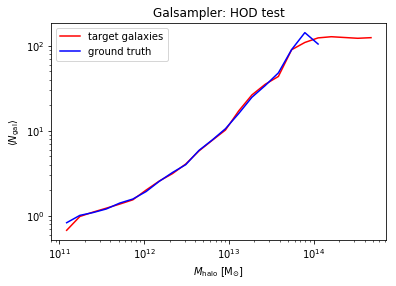

In [10]:
from halotools.mock_observables import hod_from_mock
hod_mass_bins = np.logspace(11, 14.75, 25)
hod_mass_mids = 0.5*(hod_mass_bins[:-1] + hod_mass_bins[1:])

target_hod, __ = hod_from_mock(target_gals['halo_mvir'], 
                           target_halos['halo_mvir'], haloprop_bins=hod_mass_bins)
true_hod, __ = hod_from_mock(source_gals['halo_mvir'], 
                           source_halos['halo_mvir'], haloprop_bins=hod_mass_bins)

fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.plot(hod_mass_mids, target_hod, color='red', label='target galaxies')
__=ax.plot(hod_mass_mids, true_hod, color='blue', label='ground truth')

legend = ax.legend()
xlabel = ax.set_xlabel(r'$M_{\rm halo}$ $[{\rm M_{\odot}}]$')
ylabel = ax.set_ylabel(r'$\langle N_{\rm gal}\rangle$')
title = ax.set_title(r'Galsampler: HOD test')
figname = 'galsampler_HOD_test.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [11]:
from halotools.mock_observables import return_xyz_formatted_array, tpcf

target_gals_pos = return_xyz_formatted_array(target_gals['x'], 
                                             target_gals['y'], target_gals['z'])
all_source_gals_pos = return_xyz_formatted_array(source_gals['x'], 
                                             source_gals['y'], source_gals['z'])

rbins = np.logspace(-1, 1.25, 25)

xi_target_gals = tpcf(target_gals_pos, rbins, period=250)

xi_all_source_gals = tpcf(all_source_gals_pos, rbins, period=62.5)

/Library/Python/2.7/site-packages/halotools/mock_observables/two_point_clustering/clustering_helpers.py:134: UserWarning: 
 `sample1` exceeds `max_sample_size` 
downsampling `sample1`...
  warn(msg)


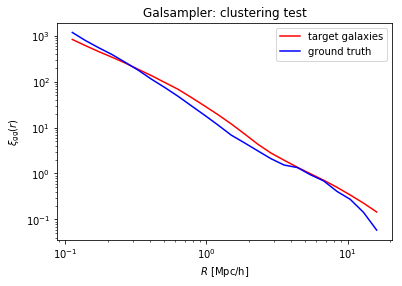

In [12]:
fig, ax = plt.subplots(1, 1)

rmids = 0.5*(rbins[:-1] + rbins[1:])
__=ax.loglog()

__=ax.plot(rmids, xi_target_gals, label='target galaxies', color='red')
__=ax.plot(rmids, xi_all_source_gals, label='ground truth', color='blue')

legend = ax.legend()
xlabel = ax.set_xlabel(r'$R$ $[{\rm Mpc/h}]$')
ylabel = ax.set_ylabel(r'$\xi_{\rm gg}(r)$')
title = ax.set_title(r'Galsampler: clustering test')
figname = 'galsampler_clustering_test.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [13]:
sim1_hod_mass_mids, sim1_target_hod = hod_mass_mids, target_hod
sim1_rmids, sim1_xi_target_gals = rmids, xi_target_gals

### Simulating 2 sims combination, Deviate from Cell 5

In [14]:
temp_source_halos = source_halos
temp_source_gals = source_gals
temp_target_halos = target_halos

number_of_sims = 2
masscut1 = [0,10.**13]
masscut2 = [10.**13.5,10.**28]
source_halos = [None]*number_of_sims
target_halos = [None]*number_of_sims
source_gals = [None]*number_of_sims
target_gals = [None]*number_of_sims

source_halos[0] = temp_source_halos[temp_source_halos['z']<31.25]
source_halos[1] = temp_source_halos[temp_source_halos['z']>31.25]
source_gals[0] = temp_source_gals[temp_source_gals['halo_z']<31.25]
source_gals[1] = temp_source_gals[temp_source_gals['halo_z']>31.25]

In [15]:
from numpy.random import choice
from astropy.table import vstack

for i in range(number_of_sims):
    target_halos[i] = temp_target_halos[(temp_target_halos['halo_mvir']>masscut1[i])*(temp_target_halos['halo_mvir']<masscut2[i])]
    
    #randomly choose ~half from first sample
    if i!=(number_of_sims-1):
        #choose overlapped halo IDs
        elimhaloid = target_halos[i][target_halos[i]['halo_mvir']>masscut1[i+1]]['halo_id']
        
        #choose about half of them to remove, keep the ids
        elimhaloid = choice(elimhaloid,size=len(elimhaloid)/2)
        
        #eliminate the chosen id's from source_halos and source_gals
        mask = np.ones(len(target_halos[i]),dtype=bool)
        mask[np.where(np.in1d(target_halos[i]['halo_id'],elimhaloid))]=False
        target_halos[i] = target_halos[i][mask]
    
    #pull eliminated halos from first from second sample
    if i!=0:
        #remove overlapped region, and keep it separate
        mask = target_halos[i]['halo_mvir']<masscut2[i-1] 
        new_halos = target_halos[i][mask] 
        target_halos[i] = target_halos[i][~mask] 
        
        #from overlapped, choose halos removed by first sample
        new_halos = new_halos[np.where(np.in1d(new_halos['halo_id'],addhaloid))]
        target_halos[i] = vstack(target_halos[i],new_halos)

    #eliminated in this loop will get added back in next
    addhaloid = elimhaloid

In [16]:
from galsampler import halo_bin_indices

for i in range(number_of_sims):
    mhost_min = target_halos[i]['halo_mvir'].min()
    mhost_max = target_halos[i]['halo_mvir'].max()
    log_mhost_min, log_mhost_max = np.log10(mhost_min), np.log10(mhost_max)
    mhost_bins = np.logspace(log_mhost_min, 14.75, 30)
    
    source_halos[i]['bin_number'] = halo_bin_indices(mass=(source_halos[i]['halo_mvir'], mhost_bins))
    target_halos[i]['bin_number'] = halo_bin_indices(mass=(target_halos[i]['halo_mvir'], mhost_bins))

In [17]:
from galsampler import source_galaxy_selection_indices

for i in range(number_of_sims):
    source_galaxies_host_halo_id = source_gals[i]['halo_hostid']
    source_halos_bin_number = source_halos[i]['bin_number']
    source_halos_halo_id = source_halos[i]['tree_id']
    target_halos_bin_number = target_halos[i]['bin_number']
    target_halo_ids = target_halos[i]['halo_id']
    nhalo_min = 1
    bins = mhost_bins
    
    results = source_galaxy_selection_indices(source_galaxies_host_halo_id, 
                            source_halos_bin_number, source_halos_halo_id, 
                            target_halos_bin_number, target_halo_ids, 
                            nhalo_min, bins)
    selection_indices, target_galaxy_target_halo_ids, target_galaxy_source_halo_ids = results
    
    target_gals[i] = Table()
    target_gals[i]['target_halo_id'] = target_galaxy_target_halo_ids
    target_gals[i]['source_halo_id'] = target_galaxy_source_halo_ids
    
    keys_to_inherit_from_source = ('host_centric_x', 'host_centric_y', 
                                   'host_centric_z', 'sm', 'sfr', 'u_mag')
    for key in keys_to_inherit_from_source:
        target_gals[i][key] = source_gals[i][key][selection_indices]
        
    keys_to_inherit_from_target = ('halo_x', 'halo_y', 'halo_z', 'halo_mvir') 
    idxA, idxB = crossmatch(target_gals[i]['target_halo_id'], target_halos[i]['halo_id'])
    for key in keys_to_inherit_from_target:
        target_gals[i][key] = 0.
        target_gals[i][key][idxA] = target_halos[i][key][idxB]
    
    target_gals[i]['x'] = target_gals[i]['halo_x'] + target_gals[i]['host_centric_x']
    target_gals[i]['y'] = target_gals[i]['halo_y'] + target_gals[i]['host_centric_y']
    target_gals[i]['z'] = target_gals[i]['halo_z'] + target_gals[i]['host_centric_z']
    
    from halotools.empirical_models import enforce_periodicity_of_box
    target_gals[i]['x'] = enforce_periodicity_of_box(target_gals[i]['x'], 250.)
    target_gals[i]['y'] = enforce_periodicity_of_box(target_gals[i]['y'], 250.)
    target_gals[i]['z'] = enforce_periodicity_of_box(target_gals[i]['z'], 250.)

In [18]:
source_halos = vstack(source_halos)
target_halos = vstack(target_halos)
source_gals =  vstack(source_gals)
target_gals =  vstack(target_gals)

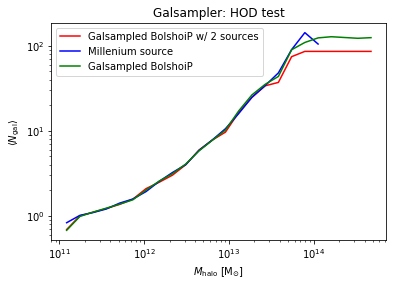

In [19]:
from halotools.mock_observables import hod_from_mock
hod_mass_bins = np.logspace(11, 14.75, 25)
hod_mass_mids = 0.5*(hod_mass_bins[:-1] + hod_mass_bins[1:])

target_hod, __ = hod_from_mock(target_gals['halo_mvir'], 
                           target_halos['halo_mvir'], haloprop_bins=hod_mass_bins)
true_hod, __ = hod_from_mock(source_gals['halo_mvir'], 
                           source_halos['halo_mvir'], haloprop_bins=hod_mass_bins)

fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.plot(hod_mass_mids, target_hod, color='red', label='Galsampled BolshoiP w/ 2 sources')
__=ax.plot(hod_mass_mids, true_hod, color='blue', label='Millenium source')
__=ax.plot(sim1_hod_mass_mids, sim1_target_hod, color='green', label='Galsampled BolshoiP')
sim1_hod_mass_mids, sim1_target_hod

legend = ax.legend()
xlabel = ax.set_xlabel(r'$M_{\rm halo}$ $[{\rm M_{\odot}}]$')
ylabel = ax.set_ylabel(r'$\langle N_{\rm gal}\rangle$')
title = ax.set_title(r'Galsampler: HOD test')
figname = 'galsampler_HOD_test.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [20]:
from halotools.mock_observables import return_xyz_formatted_array, tpcf

target_gals_pos = return_xyz_formatted_array(target_gals['x'], 
                                             target_gals['y'], target_gals['z'])
all_source_gals_pos = return_xyz_formatted_array(source_gals['x'], 
                                             source_gals['y'], source_gals['z'])

rbins = np.logspace(-1, 1.25, 25)

xi_target_gals = tpcf(target_gals_pos, rbins, period=250)

xi_all_source_gals = tpcf(all_source_gals_pos, rbins, period=62.5)

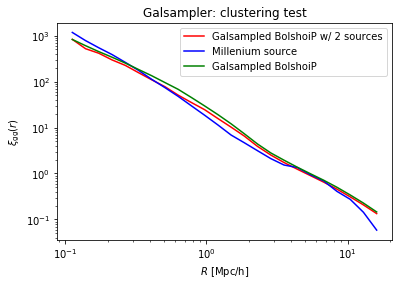

In [21]:
fig, ax = plt.subplots(1, 1)

rmids = 0.5*(rbins[:-1] + rbins[1:])
__=ax.loglog()

__=ax.plot(rmids, xi_target_gals, label='Galsampled BolshoiP w/ 2 sources', color='red')
__=ax.plot(rmids, xi_all_source_gals, label='Millenium source', color='blue')
__=ax.plot(sim1_rmids, sim1_xi_target_gals, label='Galsampled BolshoiP', color='green')

legend = ax.legend()
xlabel = ax.set_xlabel(r'$R$ $[{\rm Mpc/h}]$')
ylabel = ax.set_ylabel(r'$\xi_{\rm gg}(r)$')
title = ax.set_title(r'Galsampler: clustering test')
figname = 'galsampler_clustering_test.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')
